In [1]:
import numpy as np
from gwbench import network
from gwbench import snr
from gwbench import basic_relations as br
from gwbench import waveform as wfc

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import minimize
import dill
from pycbc import conversions as conv

import gwbench_network_funcs as gwnet


In [2]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [3]:
def get_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()
    # # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    

    # # calculate the network and detector Fisher matrices, condition numbers,
    # # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    # # calculate the 90%-credible sky area (in deg)
    # net.calc_sky_area_90()
    

    return net


In [4]:
def get_hybrid_network_response(inj_params, f_min=5., f_max=1024.,
        network_key = None,
        network_spec = ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3'],
        approximant1='IMRPhenomXAS', approximant2='IMRPhenomD',
        deriv_symbs_string = 'Mc eta chi1z chi2z DL tc phic iota ra dec psi',
        cond_num=1e25):

    # if plain text network key is passed, override full network_spec
    if network_key is not None:
        network_spec = network_dict[network_key]


    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name =  'lal_hybrid_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name, wf_other_var_dic = {'approximant1': approximant1,
                                                       'approximant2': approximant2
                                                       })
    # pick the desired frequency range
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )

    # compute the WF polarizations
    net.calc_wf_polarizations()
    # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    # calculate the network and detector Fisher matrices, condition numbers,
    # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    # compute the cutler-vallisneri bias with respect to the approximant1 waveform model
    wf_true = wfc.Waveform(wf_model_name = 'lal_bbh', wf_other_var_dic = {'approximant': approximant1})
    net.calc_cutler_vallisneri_bias(wf=wf_true)

    return net

In [5]:
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
DL = Planck18.luminosity_distance(2).value
DL

15924.566651659155

For given 'true' and 'approximate' waveforms $h_{TR}$ and $h_{AP}$, the systematic error due to waveform inaccuracy on the parameter $\theta^i$ is given by:
$$ \Delta \theta^i = (\Gamma_{AP}^{-1})^{ij} \quad  \Sigma_{D=1}^{N_{det}}  (\partial_j (h_{AP})_D | (h_{TR})_D - (h_{AP})_D)$$


We will assume that IMRPhenomXAS is $h_{TR}$ (net1) and IMRPhenomD is $h_{AP}$ (net2).


# GW150914

https://arxiv.org/pdf/1606.01210.pdf

In [6]:
name = 'GW150914'

# Detector frame
Mc = 30.8 #M_sol
m1 = 38.7 #M_sol
m2 = 32.5 #M_sol
DL = 440 #Mpc
q = m2/m1

chi_eff = -0.04
chi_p = 0.32
a1 = 0.26
a2 = 0.32

# Mc = conv.mchirp_from_mass1_mass2(m1, m2)
eta = conv.eta_from_mass1_mass2(m1, m2)

print(eta)

0.24810432710516347


In [9]:
# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0,
    'hybr': 0.0
    }


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))


net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

# net_true.save_network(f'gwbench_networks/net_xas_{name}')
# net_ap.save_network(f'gwbench_networks/net_d_{name}')

2023-11-11 12:55:42,548 - Network - INFO : Polarizations calculated.
2023-11-11 12:55:42,549 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-11 12:55:42,565 - Network - INFO : Polarizations calculated.


2023-11-11 12:55:43,789 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-11 12:55:43,838 - Network - INFO : PSDs loaded.
2023-11-11 12:55:43,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-11 12:55:43,872 - Network - INFO : Detector responses calculated.
2023-11-11 12:55:43,873 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-11 12:55:43,874 - Network - INFO :    CE-40_C
2023-11-11 12:55:44,720 - Network - INFO :    CE-20_S
2023-11-11 12:55:46,116 - Network - INFO :    ET_ET1
2023-11-11 12:55:47,386 - Network - INFO :    ET_ET2
2023-11-11 12:55:49,820 - Network - INFO :    ET_ET3
2023-11-11 12:55:51,777 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-11 12:55:51,782 - Network - INFO : SNRs calculated.
2023-11-11 12:55:51,784 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-11 12:55:51,785 - Network - INFO :    CE-40_C
2023-11-11 12:55:51,892 - Network - INFO :

# GW190521

In [137]:
# https://arxiv.org/ftp/arxiv/papers/2009/2009.01075.pdf

name = 'GW190521'

# source frame
m1 = 85 #M_sol
m2 = 66 #M_sol
DL = 5300 #Mpc
q = m2/m1

chi_eff = 0.08
chi_p = 0.68
a1 = 0.69
a2 = 0.73

z = z_at_value(Planck18.luminosity_distance, DL * u.Mpc)

Mc = conv.mchirp_from_mass1_mass2(m1, m2) * (1+z)
eta = conv.eta_from_mass1_mass2(m1, m2)

print(Mc)
print(eta)
print(z)

118.31185987676761
0.2460418402701636
0.817380878297575


In [11]:
# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0,
    'hybr': 0.
    }


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))


net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)


# net1.save_network(f'gwbench_networks/net_xas_{name}')
# net2.save_network(f'gwbench_networks/net_d_{name}')



2023-11-11 12:56:09,051 - Network - INFO : Polarizations calculated.
2023-11-11 12:56:09,052 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-11 12:56:09,063 - Network - INFO : Polarizations calculated.
2023-11-11 12:56:10,952 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-11 12:56:11,014 - Network - INFO : PSDs loaded.
2023-11-11 12:56:11,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-11 12:56:11,062 - Network - INFO : Detector responses calculated.
2023-11-11 12:56:11,063 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-11 12:56:11,064 - Network - INFO :    CE-40_C
2023-11-11 12:56:12,617 - Network - INFO :    CE-20_S
2023-11-11 12:56:13,972 - Network - INFO :    ET_ET1
2023-11-11 12:56:15,490 - Network - INFO :    ET_ET2
2023-11-11 12:56:16,778 - Network - INFO :    ET_ET3
2023-11-11 12:56:18,284 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-11 1

# GW190412

In [155]:
# https://arxiv.org/ftp/arxiv/papers/2004/2004.08342.pdf

name = 'GW190412'

# src frame
m1_src = 30.1 #M_sol
m2_src = 8.3 #M_sol

# detector frame
m1 = 34.6 #M_sol
m2 = 9.6 #M_sol
DL = 740 #Mpc
q = m2/m1

chi_eff = 0.25
chi_p = 0.31
a1 = 0.44

a2 = 0 # is actually unconstrained


# z = z_at_value(Planck18.luminosity_distance, DL * u.Mpc)

Mc = conv.mchirp_from_mass1_mass2(m1, m2)
eta = conv.eta_from_mass1_mass2(m1, m2)

print(Mc)
print(eta)
# print(z)

15.265953852928273
0.17002108883929484


In [19]:
# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0.,
    'hybr': 0.
    }

net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))


net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)


# net1.save_network(f'gwbench_networks/net_xas_{name}')
# net2.save_network(f'gwbench_networks/net_d_{name}')



2023-11-11 12:58:41,497 - Network - INFO : Polarizations calculated.
2023-11-11 12:58:41,498 - Network - INFO : Calculate numeric derivatives of polarizations.


2023-11-11 12:58:41,515 - Network - INFO : Polarizations calculated.
2023-11-11 12:58:42,546 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-11 12:58:42,600 - Network - INFO : PSDs loaded.
2023-11-11 12:58:42,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-11 12:58:42,631 - Network - INFO : Detector responses calculated.
2023-11-11 12:58:42,632 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-11 12:58:42,632 - Network - INFO :    CE-40_C
2023-11-11 12:58:43,380 - Network - INFO :    CE-20_S
2023-11-11 12:58:44,126 - Network - INFO :    ET_ET1
2023-11-11 12:58:44,979 - Network - INFO :    ET_ET2
2023-11-11 12:58:46,044 - Network - INFO :    ET_ET3
2023-11-11 12:58:47,232 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-11 12:58:47,236 - Network - INFO : SNRs calculated.
2023-11-11 12:58:47,237 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-11 12:58:47,238 - N

# GW151226

In [84]:
# https://arxiv.org/ftp/arxiv/papers/1606/1606.04855.pdf

name = 'GW151226'

# src frame
m1_src = 14.2 #M_sol
m2_src = 7.5 #M_sol

# detector frame
DL = 440 #Mpc


chi_eff = 0.25
chi_p = 0.4


Mc = 8.9
eta = conv.eta_from_mass1_mass2(m1_src, m2_src)

print(Mc)
print(eta)


# set the injection parameters
inj_params = {
    'name': name,
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0.,
    'hybr': 0.
    }

# net_key = '3G'
net_key = 'aLIGO'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))


net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)


# net1.save_network(f'gwbench_networks/net_xas_{name}')
# net2.save_network(f'gwbench_networks/net_d_{name}')



2023-11-11 13:18:46,301 - Network - INFO : Polarizations calculated.
2023-11-11 13:18:46,302 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-11 13:18:46,314 - Network - INFO : Polarizations calculated.


8.9
0.2261674701097921


2023-11-11 13:18:49,656 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-11 13:18:49,909 - Network - INFO : PSDs loaded.
2023-11-11 13:18:49,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-11 13:18:49,956 - Network - INFO : Detector responses calculated.
2023-11-11 13:18:49,957 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-11 13:18:49,957 - Network - INFO :    aLIGO_H
2023-11-11 13:18:52,905 - Network - INFO :    aLIGO_L
2023-11-11 13:18:55,058 - Network - INFO :    V+_V
2023-11-11 13:18:57,426 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-11 13:18:57,429 - Network - INFO : SNRs calculated.
2023-11-11 13:18:57,430 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-11 13:18:57,430 - Network - INFO :    aLIGO_H
2023-11-11 13:18:57,520 - Network - INFO :    aLIGO_L
2023-11-11 13:18:57,608 - Network - INFO :    V+_V
2023-11-11 13:18:57,735 - Network - INFO : Er

# Detector Responses

In [8]:
import pycbc

pycbc.detector.get_available_detectors()

[('T1', 'TAMA_300'),
 ('V0', 'VIRGO_CITF'),
 ('V1', 'VIRGO'),
 ('G1', 'GEO_600'),
 ('H2', 'LHO_2k'),
 ('H1', 'LHO_4k'),
 ('L1', 'LLO_4k'),
 ('I1', 'LIO_4k'),
 ('C1', 'CIT_40'),
 ('E1', 'ET1_T1400308'),
 ('E2', 'ET2_T1400308'),
 ('E3', 'ET3_T1400308'),
 ('E0', 'ET0_T1400308'),
 ('K1', 'KAGRA'),
 ('U1', 'ACIGA'),
 ('A1', 'ALLEGRO_320'),
 ('O1', 'AURIGA'),
 ('X1', 'EXPLORER'),
 ('N1', 'Nautilus'),
 ('B1', 'NIOBE')]

In [154]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

apx = 'IMRPhenomXAS'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=14.5,
                         mass2=7.2,
                         spin1z=0.,
                         spin2z=0.,
                         distance=10,
                         inclination=0.,
                         coa_phase=2.45,
                         delta_t=1.0/4096,
                         f_lower=5.)

det_l1 = Detector('L1')
det_3g = Detector('E1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.


end_time = 1192529720
declination = 0.65
right_ascension = 4.67
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_3g = det_3g.project_wave(hp, hc,  right_ascension, declination, polarization)


# Generate noise
flow = 20.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOAdVO3LowT1800545(flen, delta_f, flow)
delta_t = 1.0/4096
ts = pycbc.noise.noise_from_psd(len(signal_l1.sample_times), delta_t, psd, seed=124)

# Generate 3G noise
flow = 5.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
delta_t = 1.0/4096
ts_3g = pycbc.noise.noise_from_psd(len(signal_3g.sample_times), delta_t, psd, seed=124)

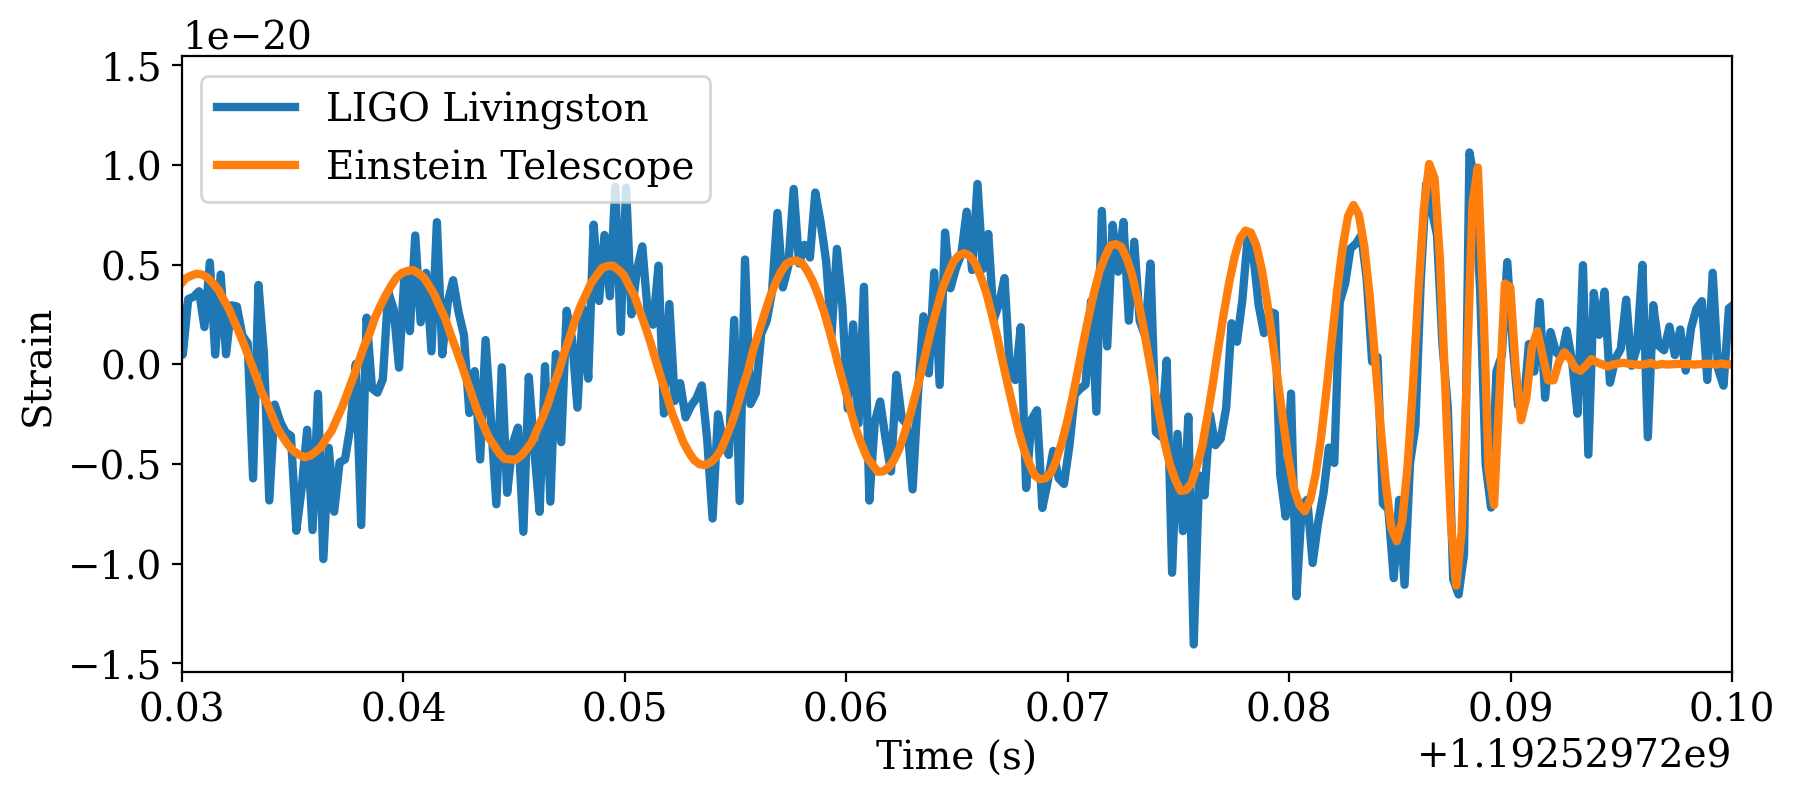

In [187]:
fig, ax= plt.subplots(1, 1,  figsize=(10,4))

pp.plot(signal_l1.sample_times - 0.0204, signal_l1.data +ts.data, lw=3, label='LIGO Livingston')

pp.plot(signal_3g.sample_times , signal_3g.data + ts_3g.data, lw=3, label='Einstein Telescope')

# pp.plot(signal_l1.sample_times, signal_l1.data, label='Signal', color='k')
# pp.plot(signal_3g.sample_times, signal_3g.data, label='Signal', color='k', ls='--')



plt.xlim(719.93+1.192529e9, 720+1.192529e9)
# plt.yscale('symlog')
pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend(fontsize=14)
pp.show()

# Plot Biases

In [20]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z} \;\;\,$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z \;\;\;\;\;\;$',
    'm1_det': '$m_{1, \\rm det}$',
    'm2_det': '$m_{2, \\rm det}$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q \;\;\;\;\;\;\,$',
    'm_tot': '$M_{\\rm total}$'
}

In [93]:
import scipy.stats as stats

def plot_bias(net_ap, vars, labels):
    if len(vars)==1:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 3))
        ax = [ax]
    else:
        fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(8, 3*len(vars)))
        ax = list(axes)
    

    for i, param in enumerate((vars)):
        mu = net_ap.inj_params[param]
        sigma = net_ap.errs[param]/21
        index = net_ap.deriv_variables.index(param)
        bias = net_ap.cutler_vallisneri_bias.tolist()[0][index]

        x = np.linspace(mu-4*np.abs(bias), mu+4*np.abs(bias), 10000)
        if (param == 'chi1z' or param == 'chi2z'):
            x = np.linspace(-1, 1, 10000)
        if (param == 'q'):
            x = np.linspace(0, 1, 10000)
        if (param == 'eta'):
            x = np.linspace(0, 0.25, 10000)

        inj_est = stats.norm.pdf(x, mu, sigma)
        inj_est = inj_est/np.sum(inj_est)

        biased_est = stats.norm.pdf(x, mu+bias, sigma)
        biased_est = biased_est/ np.sum(biased_est)

        # print(bias/sigma)
        
        ax[i].plot(x, inj_est, label='Waveform Model 1', color='tab:blue', lw=2)
        ax[i].plot(x, biased_est, label='Waveform Model 2',color='orangered', lw=2)


        ax[i].set_xlabel(labels[param])
        ax[i].set_ylabel(f"p({labels[param]})")
        
        # if i==0:
        #     ax[i].legend(fontsize=12)


    # plt.suptitle( " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    # plt.show()

(8.86, 8.96)

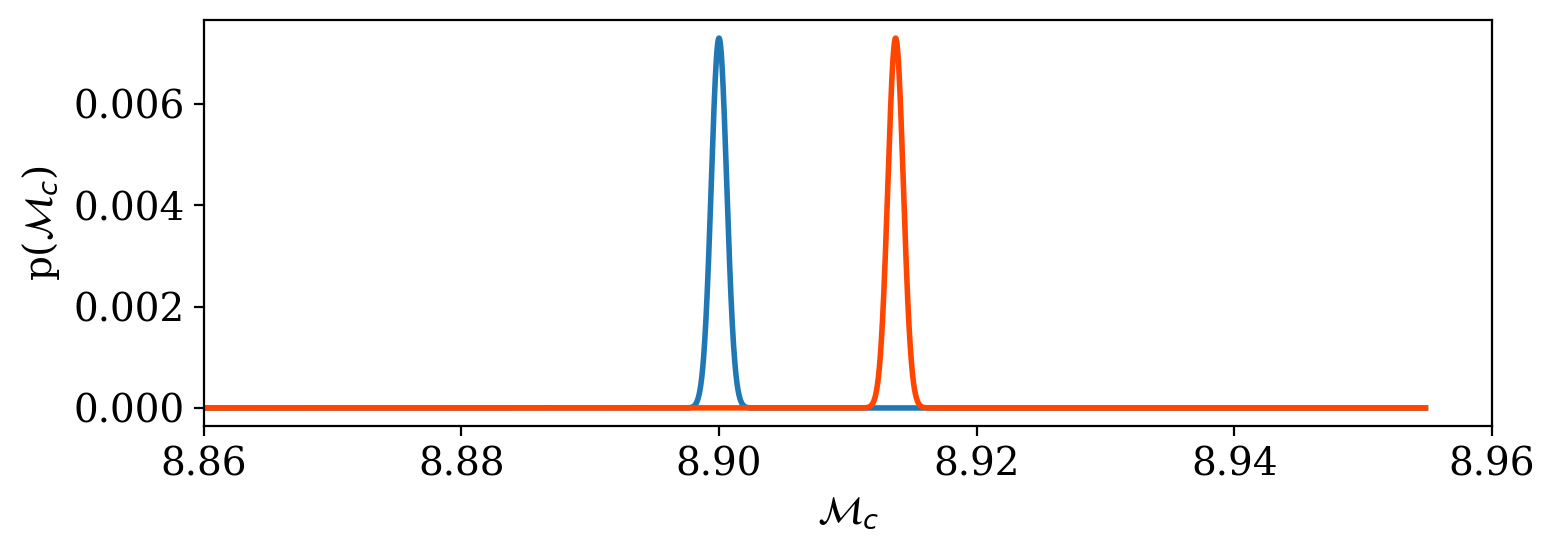

In [94]:
vars = ['Mc']
plot_bias(net_ap, vars, labels)
plt.xlim(8.86, 8.96)

# Load gwbench networks

In [5]:
name='GW150914'
# name='GW190521'
# name='GW190412'

with open(f'gwbench_networks/net_xas_{name}', "rb") as fi:
    net1 = dill.load(fi)

with open(f'gwbench_networks/net_d_{name}', "rb") as fi:
    net2 = dill.load(fi)

# Study the covariance terms

In [11]:
print(net_hybr.inj_params["Mc"])
print(net_hybr.snr)
print(net_hybr.errs["DL"])
net_hybr.deriv_symbs_string

30.8
1663.5346973982607
0.6805825


'Mc eta chi1z chi2z DL tc phic iota ra dec psi'

In [20]:
def plot_cov_terms(interesting_param, net):
    param_list = net.deriv_symbs_string.split()

    index = param_list.index(interesting_param)
    cov = net.cov[index]

    print(f"{interesting_param} error = ", net.errs[interesting_param])
    print(f"{interesting_param} bias = {net.cutler_vallisneri_bias[0, index]:.2f} = {net.cutler_vallisneri_bias[0, index]/net.errs[interesting_param]:.1f} σ")
    print()
    print(f"Covariance with {interesting_param}:")
    for i, param in enumerate(param_list):
        print(f"σ_{param} * σ_{interesting_param} = ", cov[0,i])
        
        edge=None
        if cov[0,i] < 0: edge = 'black'
        plt.scatter(i, np.abs(cov[0,i]), edgecolor=edge)

    plt.axhline(y=0, ls='--', color='k')
    plt.xticks(range(len(param_list)), param_list, rotation='vertical')
    plt.grid()
    ylabel = str("|$\sigma_p$ * $\sigma$_" +interesting_param+ "|")
    plt.ylabel(ylabel)
    plt.xlabel(f"p")

    plt.yscale('log')
    plt.show()


DL error =  0.6805825
DL bias = 792.73 = 1164.8 σ

Covariance with DL:
σ_Mc * σ_DL =  -3.2665153e-06
σ_eta * σ_DL =  4.2611853e-05
σ_chi1z * σ_DL =  -0.0047356463
σ_chi2z * σ_DL =  0.0056535443
σ_DL * σ_DL =  0.46319258
σ_tc * σ_DL =  2.011668e-05
σ_phic * σ_DL =  0.0009133114
σ_iota * σ_DL =  -0.00076765433
σ_ra * σ_DL =  1.1348764e-05
σ_dec * σ_DL =  -5.5796434e-05
σ_psi * σ_DL =  0.00011631759


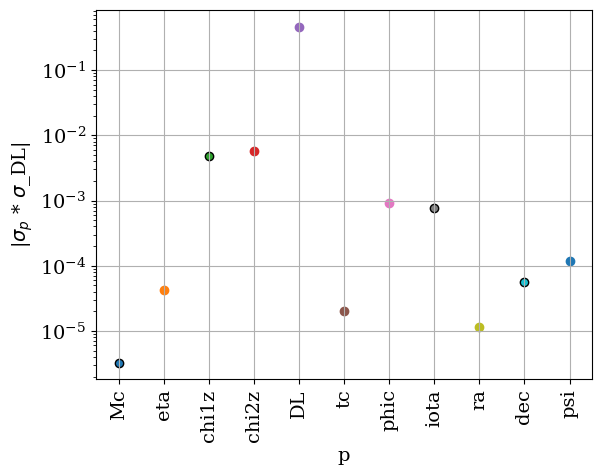

In [21]:
plot_cov_terms(interesting_param = "DL", net=net_hybr)

Mc error =  0.00044323227
Mc bias = 0.16 = 371.6 σ

Covariance with Mc:
σ_Mc * σ_Mc =  1.9645485e-07
σ_eta * σ_Mc =  1.1975232e-08
σ_chi1z * σ_Mc =  -5.387669e-06
σ_chi2z * σ_Mc =  6.807899e-06
σ_DL * σ_Mc =  -3.2665153e-06
σ_tc * σ_Mc =  2.518933e-08
σ_phic * σ_Mc =  -5.2137904e-07
σ_iota * σ_Mc =  2.7760091e-08
σ_ra * σ_Mc =  -1.1753604e-08
σ_dec * σ_Mc =  8.925587e-09
σ_psi * σ_Mc =  -5.1671316e-09


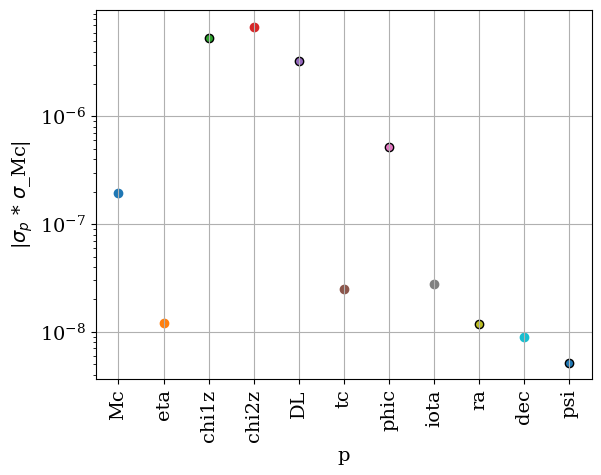

In [90]:
plot_cov_terms(interesting_param = "Mc", net=net_hybr)

chi2z error =  0.06775874
chi2z bias = 29.75 = 439.1 σ

Covariance with chi2z:
σ_Mc * σ_chi2z =  6.807899e-06
σ_eta * σ_chi2z =  2.8366843e-05
σ_chi1z * σ_chi2z =  -0.0038080364
σ_chi2z * σ_chi2z =  0.0045912466
σ_DL * σ_chi2z =  0.0056535443
σ_tc * σ_chi2z =  1.6587468e-05
σ_phic * σ_chi2z =  0.00056214037
σ_iota * σ_chi2z =  6.934371e-07
σ_ra * σ_chi2z =  -4.2073998e-07
σ_dec * σ_chi2z =  4.048099e-07
σ_psi * σ_chi2z =  1.2031809e-06


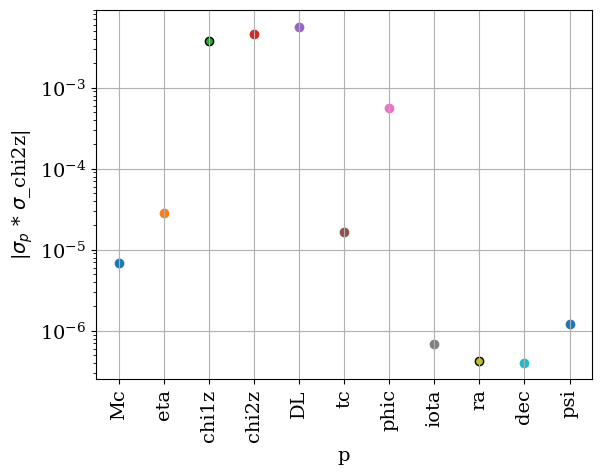

In [78]:
plot_cov_terms(interesting_param = "chi2z", net=net_hybr)

phic error =  0.009677937
phic bias = 3.56 = 367.6 σ

Covariance with phic:
σ_Mc * σ_phic =  -5.2137904e-07
σ_eta * σ_phic =  3.3520403e-06
σ_chi1z * σ_phic =  -0.00046611595
σ_chi2z * σ_phic =  0.00056214037
σ_DL * σ_phic =  0.0009133114
σ_tc * σ_phic =  2.0451464e-06
σ_phic * σ_phic =  9.366247e-05
σ_iota * σ_phic =  -1.6819956e-07
σ_ra * σ_phic =  -6.258485e-08
σ_dec * σ_phic =  -4.7918394e-07
σ_psi * σ_phic =  4.102356e-06


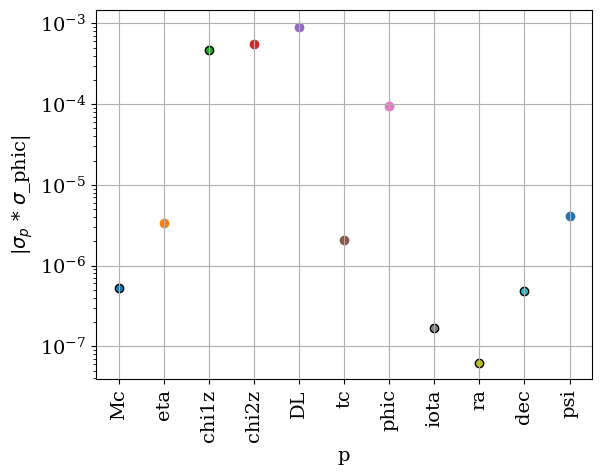

In [22]:
plot_cov_terms(interesting_param = "phic", net=net_hybr)

tc error =  0.00024508385
tc bias = 0.10 = 427.8 σ

Covariance with tc:
σ_Mc * σ_tc =  2.518933e-08
σ_eta * σ_tc =  1.00218884e-07
σ_chi1z * σ_tc =  -1.3744963e-05
σ_chi2z * σ_tc =  1.6587468e-05
σ_DL * σ_tc =  2.011668e-05
σ_tc * σ_tc =  6.006609e-08
σ_phic * σ_tc =  2.0451464e-06
σ_iota * σ_tc =  2.1928117e-09
σ_ra * σ_tc =  -1.284859e-09
σ_dec * σ_tc =  5.5446375e-10
σ_psi * σ_tc =  4.7420876e-09


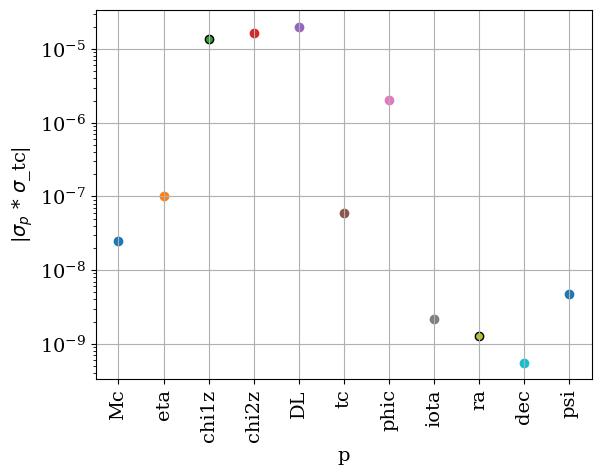

In [79]:
plot_cov_terms(interesting_param = "tc", net=net_hybr)

# Study the Bias terms

In [13]:
interesting_param = 'DL'
param_list = net_ap.deriv_symbs_string.split()
index = param_list.index(interesting_param)
print(net_ap.errs)
print(net_ap.cutler_vallisneri_bias[0,index]/ net_ap.errs[interesting_param])

{'Mc': 0.0006261309, 'eta': 0.0009858563, 'chi1z': 0.075267695, 'chi2z': 0.08837092, 'DL': 0.6895102, 'tc': 0.00030442135, 'phic': 0.011350461, 'iota': 0.001257504, 'ra': 0.0002586531, 'dec': 0.00069343334, 'psi': 0.0014201597}
1184.5728617870623


In [14]:
def plot_bias_terms(interesting_param, net1, net2, net_hybr):
    param_list = net1.deriv_symbs_string.split()
    index = param_list.index(interesting_param)
    inner_prod = np.zeros(len(param_list))

    print(f"{interesting_param} bias = {net_hybr.cutler_vallisneri_bias[0,index]:.2f}")
    cov_ap = net2.cov

    for d in range(len(net2.detectors)):
        del_h_ap_all = net2.detectors[d].del_hf
        del_params_j = list(del_h_ap_all.keys())


        h_tr = net1.detectors[d].hf
        h_ap = net2.detectors[d].hf
        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = del_h_ap_all[parameter_j]
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
            
    bias_contributions = np.multiply(cov_ap[index] , inner_prod)

    y = bias_contributions.tolist()[0]

    for i, param in enumerate(param_list):
        print(f"{param} contribution: {y[i]:.2f}")
        plt.scatter(i, y[i])

    plt.axhline(y=0, ls='--', color='k')
    plt.xticks(range(len(param_list)), param_list, rotation='vertical')
    plt.grid()
    ylabel = str("$\Delta$" +interesting_param)
    plt.ylabel(ylabel)

    plt.show()


In [15]:
plot_bias_terms("DL", net_true, net_ap, net_ap)

DL bias = 816.78


TypeError: unsupported operand type(s) for -: 'NoneType' and 'complex'

chi2z bias = 29.75
Mc contribution: 43.13
eta contribution: -470.51
chi1z contribution: 14169.17
chi2z contribution: -14252.14
DL contribution: 60.11
tc contribution: 230.08
phic contribution: 249.28
iota contribution: 3.67
ra contribution: -0.96
dec contribution: -0.31
psi contribution: -1.71


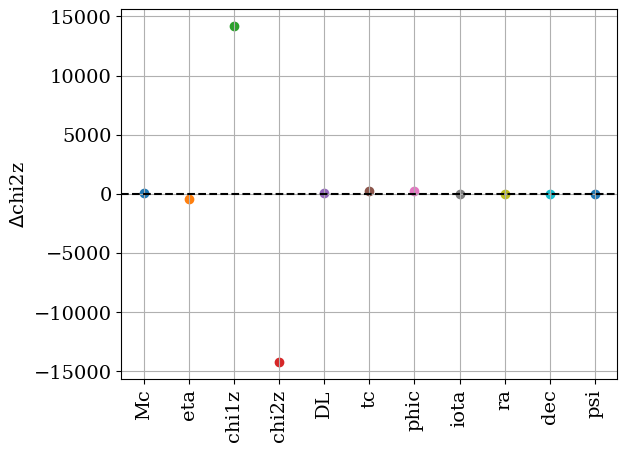

In [87]:
plot_bias_terms("chi2z", net1, net2, net_hybr)

Mc bias = 0.16
Mc contribution: 1.24
eta contribution: -0.20
chi1z contribution: 20.05
chi2z contribution: -21.13
DL contribution: -0.03
tc contribution: 0.35
phic contribution: -0.23
iota contribution: 0.15
ra contribution: -0.03
dec contribution: -0.01
psi contribution: 0.01


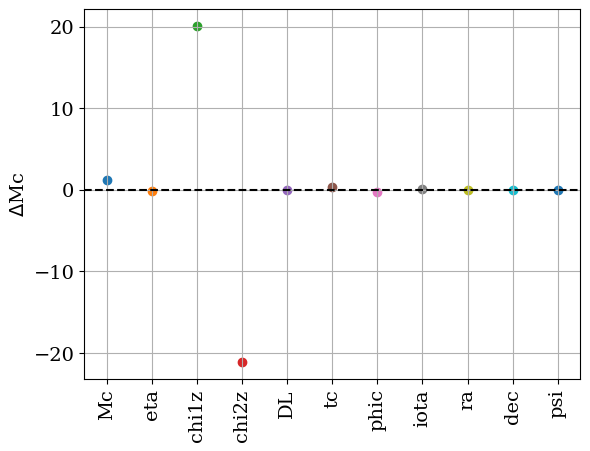

In [88]:
plot_bias_terms("Mc", net1, net2, net_hybr)

ra bias = -0.01
Mc contribution: -0.07
eta contribution: 0.05
chi1z contribution: -1.28
chi2z contribution: 1.31
DL contribution: 0.12
tc contribution: -0.02
phic contribution: -0.03
iota contribution: -0.18
ra contribution: 0.13
dec contribution: -0.01
psi contribution: -0.01


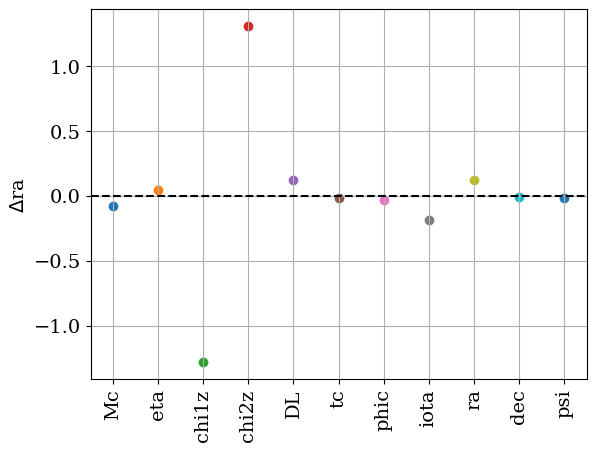

In [89]:
plot_bias_terms("ra", net1, net2, net_hybr)

# Perform Cutler-Vallisneri with (IMRPhenomXAS, IMRPhenomD) and 3G network

In [24]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Vallisneri formalism
def compute_wf_bias(net1, net2, param_list):
    inner_prod = np.zeros(len(param_list))
	
    cov_ap = net2.cov

    for d in range(len(net2.detectors)):
        del_h_ap_all = net2.detectors[d].del_hf
        del_params_j = list(del_h_ap_all.keys())
	

        h_tr = net1.detectors[d].hf
        h_ap = net2.detectors[d].hf
        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = del_h_ap_all[parameter_j]
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
    return np.dot(cov_ap, inner_prod)	

In [27]:
param_list = deriv_symbs_string.split()
errors_th = compute_wf_bias(net1, net2, param_list)
print(param_list)
print(errors_th)
print()

print(net2.errs)

print(errors_th[4]/net2.errs["DL"])


['Mc', 'eta', 'chi1z', 'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']
[[ 1.63681546e-01  2.07978420e-01 -2.47602071e+01  2.98023843e+01
   7.93172122e+02  1.05020133e-01  3.57693226e+00 -1.15480499e-02
  -8.16969416e-03 -2.01581933e-02 -4.47788384e-02]]

{'Mc': 0.0004432322, 'eta': 0.0004659815, 'chi1z': 0.05621349, 'chi2z': 0.06775871, 'DL': 0.68058676, 'tc': 0.00024508376, 'phic': 0.0096779615, 'iota': 0.0012497029, 'ra': 0.00023427882, 'dec': 0.00062948314, 'psi': 0.0014086319}


IndexError: index 4 is out of bounds for axis 0 with size 1

71.3
1.859842811243988


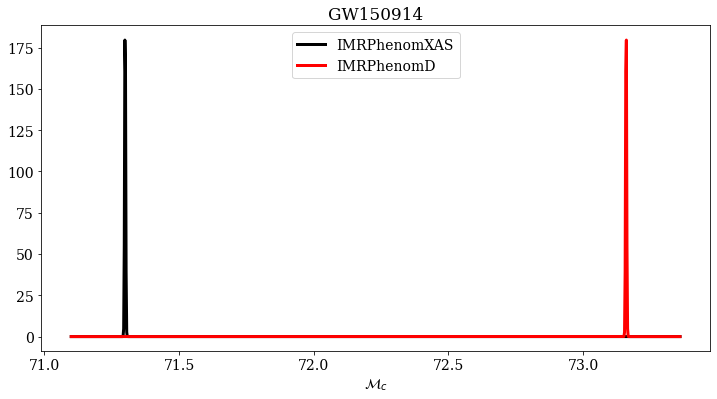

In [181]:
from scipy.stats import norm

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

mc_inj = net1.inj_params["Mc"]
stat_err = net2.errs["Mc"]
bias = errors_th[0]

print(mc_inj)
print(bias)

mc = np.linspace(mc_inj-0.2, mc_inj+bias+0.2, 1000)

plt.plot(mc, norm.pdf(mc, mc_inj, stat_err), lw=3, color='k', label="IMRPhenomXAS")
# plt.plot(mc, norm.pdf(mc, mc_inj+0.103, stat_err),lw=3, color='orange', label="$\lambda \\approx 0.1$")
plt.plot(mc, norm.pdf(mc, mc_inj+bias, stat_err),lw=3, color='r', label="IMRPhenomD")

# plt.axvline(x=mc_inj, ymin=0.05, color='k', ls='--')
# plt.axvline(x=mc_inj+0.103,  ymin=0.05, color='orange', ls='--')
# plt.axvline(x=mc_inj+bias,  ymin=0.05, color='r', ls='--')

# plt.semilogy()
plt.xlabel("$\mathcal{M}_{c}$")
plt.title(net1.inj_params["name"])
plt.legend()
plt.show()

# Plot the Bias across parameters

In [16]:
net_ap.inj_params["name"]

'GW150914'

In [17]:
def plot_bias(param_list, errors_th, figsize=(12,25)):
    f, ax= plt.subplots(len(param_list), 1,  figsize=figsize) 
    ax = list(ax)
    for i, param in enumerate((param_list)):
        mu = net2.inj_params[param]
        sigma = net2.errs[param]

        x = np.linspace(mu-3*errors_th[i], mu+3*errors_th[i], 10000)

        stat_est = stats.norm.pdf(x, mu, sigma)
        stat_est = stat_est/np.max(stat_est)

        theory_est = stats.norm.pdf(x, mu+errors_th[i], sigma)
        theory_est = theory_est/ np.max(theory_est)

        ax[i].plot(x, stat_est, label=f"Approximate (IMRPhenomD)")
        ax[i].plot(x, theory_est, label=f"True (IMRPhenomXAS)")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=14)

        
        ax[i].set_xlim(mu-2*errors_th[i], mu+3*errors_th[i])
        ax[i].set_xlabel(param, fontsize=20)

    plt.suptitle(net2.inj_params["name"] + " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

In [18]:
plot_bias(param_list[:], errors_th, figsize=(12, 20))


NameError: name 'errors_th' is not defined

# Construct Hybrid Waveform

## Antenna Pattern Calculation

In [53]:
import antenna_pattern_np as gw_ap

In [54]:
def waveform_to_det_response(hp, hc, inj_params, detector):
    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)
    return Flp * (Fp * hp + Fc * hc)    

In [55]:
h1_response = waveform_to_det_response(net1.hfp, net1.hfc, inj_params, net1.detectors[0])
h2_response = waveform_to_det_response(net2.hfp, net2.hfc, inj_params, net2.detectors[0])

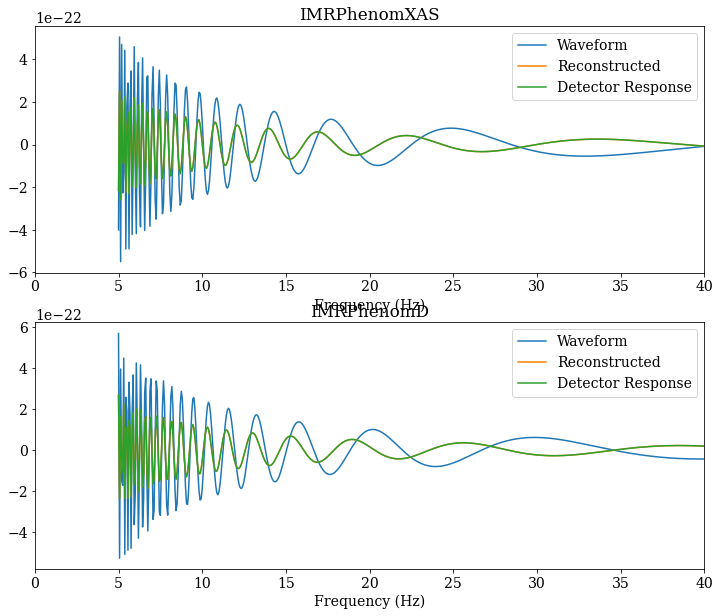

In [56]:
f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

ax[0].plot(net1.f, np.real(net1.hfp), label="Waveform")
ax[0].plot(net1.f, np.real(h1_response), label="Reconstructed")
ax[0].plot(net1.detectors[0].f, np.real(net1.detectors[0].hf), label="Detector Response")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("IMRPhenomXAS")
ax[0].set_xlim(0, 40)
ax[0].legend()

ax[1].plot(net2.f, np.real(net2.hfp), label="Waveform")
ax[1].plot(net2.f, np.real(h2_response), label="Reconstructed")
ax[1].plot(net2.detectors[0].f, np.real(net2.detectors[0].hf), label="Detector Response")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("IMRPhenomD")
ax[1].set_xlim(0, 40)
ax[1].legend()

plt.show()

## Hybrid Waveform Calculation

Let's express the two waveforms using following decompositions:
$$ h^{(1)}_{lm}(f) = A^{(1)}_{lm}(f) \exp[{i \phi^{(1)}_{lm}(f)}]$$
$$ h^{(2)}_{lm}(f) = A^{(2)}_{lm}(f) \exp[{i \phi^{(2)}_{lm}(f)}]$$

We want to minimize the initial time difference, which can be expressed as a frequency-dependent phase factor $ \exp[{i (\Delta\phi)}] = \exp[{i ( \phi_a + \phi_b f)}] $

Therefore, our task is to find a phase offset $\Delta \phi$ that minimizes the integrated phase difference 
$$ \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  (\phi^{(2)}(f)+ \Delta \phi) \;\; df $$
$$ = \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  \phi^{(2)}(f) - \phi_a - (\phi_b \cdot f) \;\; df $$

In [57]:
def phase_diff_integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max, freq_range = args[0], args[1], args[2], args[3], args[4]
    phase_diff = np.sum(phi1 - phi2)
    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))


In [58]:
def get_delta_phi(hp1, hc1, hp2, hc2, detector):
    f_min = 5.
    f_max = 1024.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)

    h1 = Flp*(Fp*hp1 + Fc*hc1)
    h2 = Flp*(Fp*hp2 + Fc*hc2)

    phi1 = np.unwrap(np.angle(h1))   
    phi2 = np.unwrap(np.angle(h2))

    initial_guess = [1.0, 0.]
    args = [phi1, phi2, f_min, f_max, f]
    result = minimize(phase_diff_integral, initial_guess, args=args, method='Nelder-Mead')
    # print(result)
    
    phi_a_opt, phi_b_opt = result.x[0], result.x[1]


    delta_phi = phi_a_opt + (phi_b_opt*f)

    return delta_phi

In [59]:
# Hybrid Waveform
def get_hyb_wf(hp1, hc1, hp2, hc2, lam, opt_phi=False, detector=net1.detectors[0]):

    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))

    # h_plus components
    a1_p = np.abs(hp1)
    phi1_p = np.unwrap(np.angle(hp1))  

    a2_p = np.abs(hp2)
    phi2_p = np.unwrap(np.angle(hp2))

    # h_cross components
    a1_c = np.abs(hc1)
    phi1_c = np.unwrap(np.angle(hc1))    

    a2_c = np.abs(hc2)
    phi2_c = np.unwrap(np.angle(hc2))

    if opt_phi:
        # Optimize for time shift of second waveform
        delta_phi = get_delta_phi(hp1, hc1, hp2, hc2, detector)
        phi2_p = (phi2_p + delta_phi) 
        phi2_c = (phi2_c + delta_phi) 

    # Construct Hybrid waveforms
    a_hyb_p = a1_p*(1-lam) + a2_p*(lam)
    phi_hyb_p = phi1_p*(1-lam) + phi2_p*(lam)

    a_hyb_c = a1_c*(1-lam) + a2_c*(lam)
    phi_hyb_c = phi1_c*(1-lam) + phi2_c*(lam)


    hp_hyb =  a_hyb_p * np.exp(1.j * phi_hyb_p)
    hc_hyb =  a_hyb_c * np.exp(1.j * phi_hyb_c)
    
    return hp_hyb, hc_hyb

In [60]:
hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam=0.5)
print(np.abs(np.sum(hp_hyb - net2.hfp)))
print(np.abs(np.sum(hc_hyb - net2.hfc)))

2.9221755094059436e-20
1.7047237963723113e-20


In [61]:
from pycbc.types import FrequencySeries
delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)
hp2_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)

hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc)/psd).data)


lams = np.linspace(0, 1, 10)
inner_prods = np.zeros(10)

for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    
    hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc)/psd).data)

    inner_prods[l] = np.abs(np.sum((hp1_pyc * np.conjugate(hp_hyb_pyc)/psd).data))
    inner_prods[l] = inner_prods[l]/ np.abs(np.sqrt(hp1_norm*hyb_norm))

print(inner_prods)

[1.         0.97878195 0.91849986 0.82909194 0.72613473 0.62875053
 0.55498186 0.51365147 0.49838705 0.493099  ]


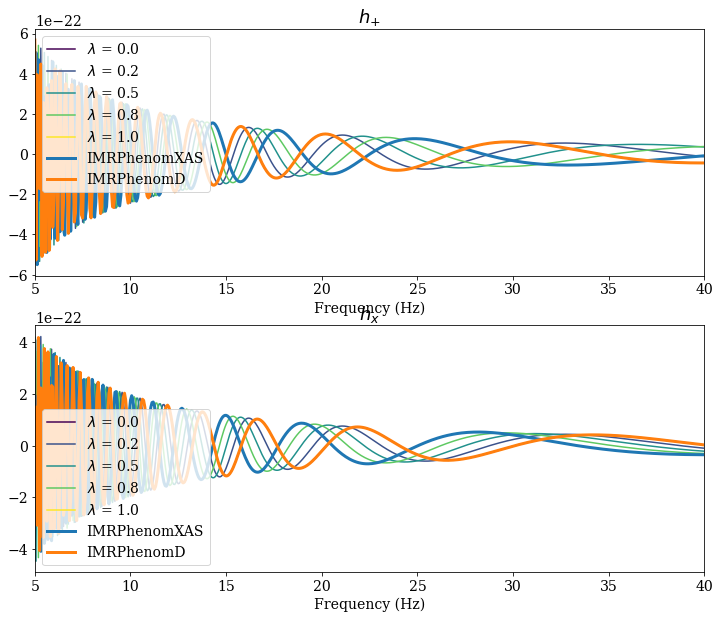

In [62]:
lams = np.linspace(0., 1., 5)
colors = plt.cm.viridis(lams)

f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

for i, lam in enumerate(lams):
    # hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam)
    ax[0].plot(net2.f, np.real(hp_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")
    ax[1].plot(net2.f, np.real(hc_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")

ax[0].plot(net1.f, np.real(net1.hfp), lw=3, label="IMRPhenomXAS")
ax[0].plot(net2.f, np.real(net2.hfp), lw=3, label="IMRPhenomD")

ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("$h_{+}$", fontsize=18)

ax[1].plot(net1.f, np.real(net1.hfc), lw=3, label="IMRPhenomXAS")
ax[1].plot(net2.f, np.real(net2.hfc), lw=3, label="IMRPhenomD")

ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("$h_{x}$", fontsize=18)

ax[0].set_xlim(5, 40)
ax[0].legend()

ax[1].set_xlim(5, 40)
ax[1].legend()

plt.tight_layout
plt.show()

## Cutler-Vallisneri for Hybrid Waveforms

In [93]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Valisneri formalism
# Interpolate the 'True' waveform for ease of calculation

lams = np.linspace(0., 0.002, 10)
errors_th_lam = np.zeros((len(lams), len(param_list)))

for l, lam in enumerate(lams):
    inner_prod = np.zeros(len(param_list))
    cov_ap = np.linalg.inv(lam*net1.fisher + (1-lam)*net2.fisher)

    for d in range(len(network_spec)):
        # del_h_ap_all = net1.detectors[d].del_hf
        del_params_j = list(net1.detectors[d].del_hf.keys())

        hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=False)

        h_tr = net1.detectors[d].hf
        h_ap = waveform_to_det_response(hp_hyb, hc_hyb, inj_params, net1.detectors[d])

        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = (1-lam)*net1.detectors[d].del_hf[parameter_j]  + lam*net2.detectors[d].del_hf[parameter_j] 
            
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
        
    # Calculate the theoretical bias across parameters
    errors_th_lam[l,:] = np.dot(cov_ap, inner_prod)


In [94]:
# Print only Mc errors
print(errors_th_lam[:,0])
print(lams)

[-4.74654396e-13 -5.04782445e-03 -1.00554790e-02 -1.50232799e-02
 -1.99515399e-02 -2.48405684e-02 -2.96906717e-02 -3.45021529e-02
 -3.92753120e-02 -4.40104456e-02]
[0.         0.00022222 0.00044444 0.00066667 0.00088889 0.00111111
 0.00133333 0.00155556 0.00177778 0.002     ]


In [95]:
def plot_single_param_bias(error_th, param, lam=0., figsize=(12,25), xlim=None):
    f, ax= plt.subplots(1, 1,  figsize=figsize) 
    
    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    x = np.linspace(mu-30, mu+30, 10000)

    stat_est = stats.norm.pdf(x, mu, sigma)
    # stat_est = stat_est/np.max(stat_est)

    theory_est = stats.norm.pdf(x, mu+error_th, sigma)
    # theory_est = theory_est/ np.max(theory_est)

    ax.plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
    ax.plot(x, theory_est, label=f"Hybrid (lam={lam:.3f}) Est")
    
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=16)

    if xlim is None:
        ax.set_xlim(mu-2*error_th, mu+3*error_th)
    else:
        ax.set_xlim(xlim)
        
    ax.set_xlabel(param, fontsize=20)

    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.title("Systematic Bias b/w IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    # plt.tight_layout()
    plt.show()

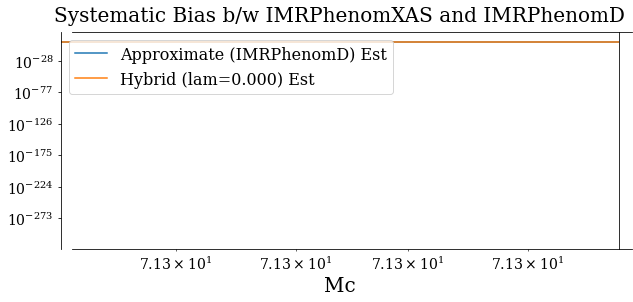

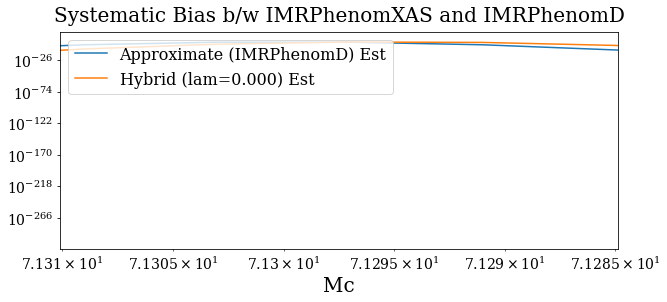

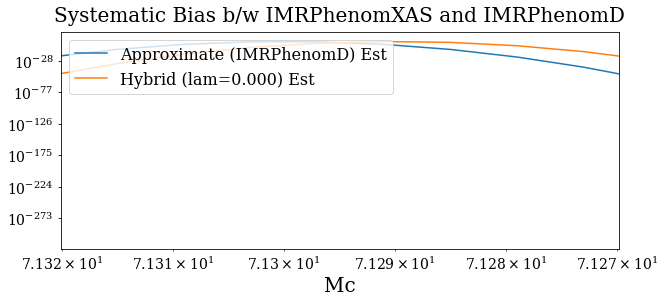

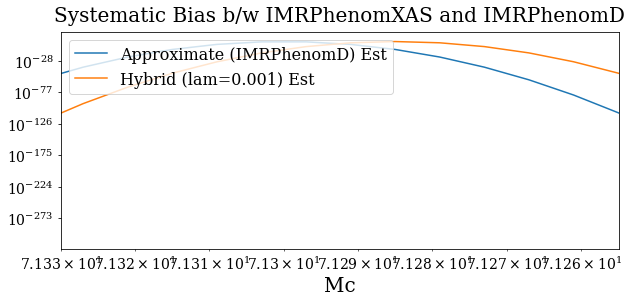

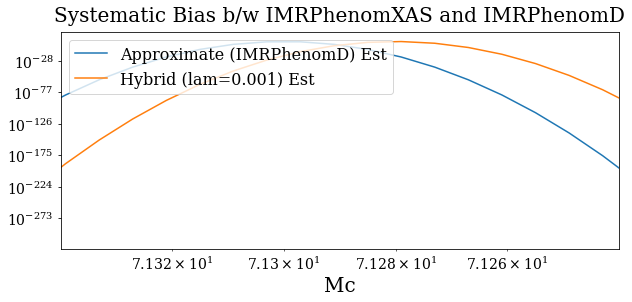

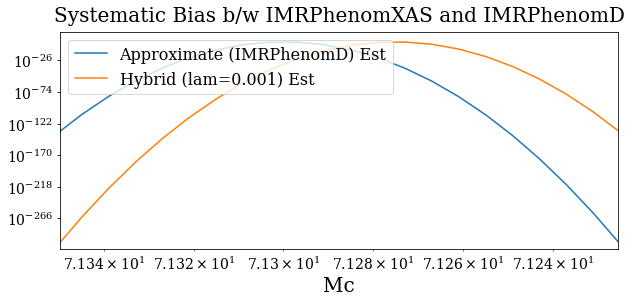

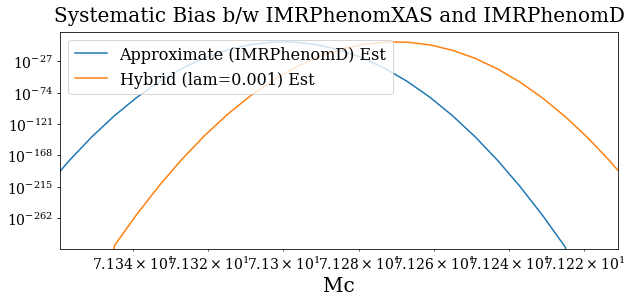

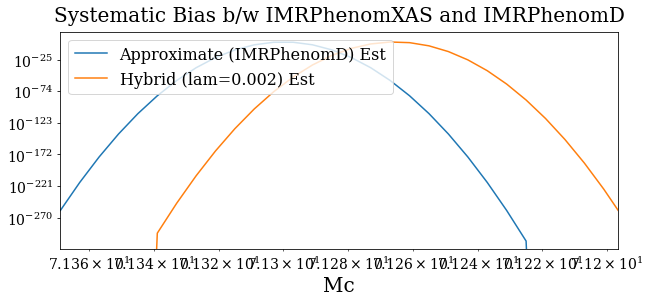

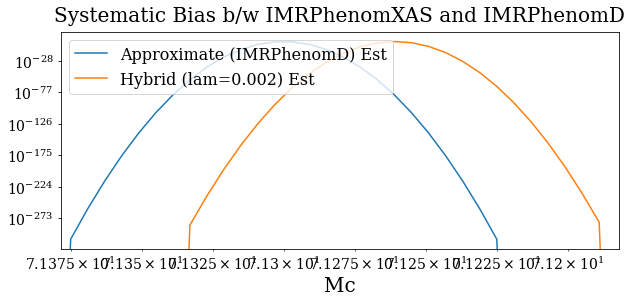

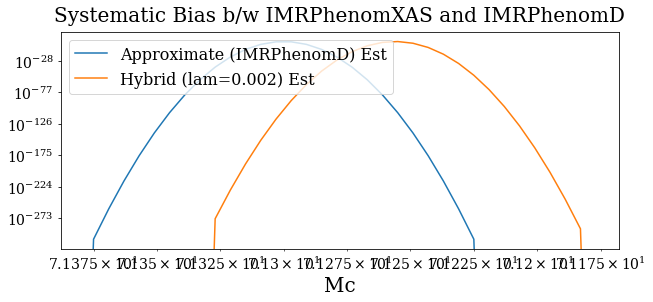

In [96]:
param = param_list
for i in range(len(lams[:])):
    plot_single_param_bias(errors_th_lam[i,0], lam=lams[i], param=param_list[0], figsize=(10, 4))

In [97]:
print(net2.errs["eta"])
errors_th_lam[:, 3]

7.549987544210043e-05


array([4.39285599e-13, 6.43073612e-03, 1.28216850e-02, 1.91731406e-02,
       2.54853937e-02, 3.17587321e-02, 3.79934406e-02, 4.41898010e-02,
       5.03480919e-02, 5.64685893e-02])

# Plot bias vs lambda

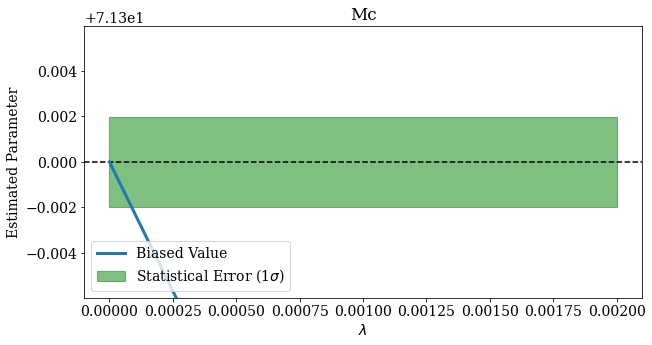

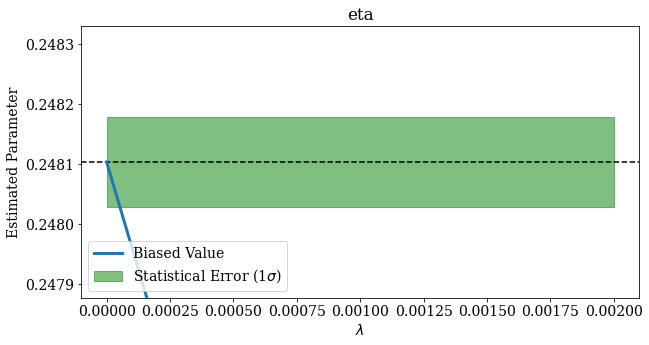

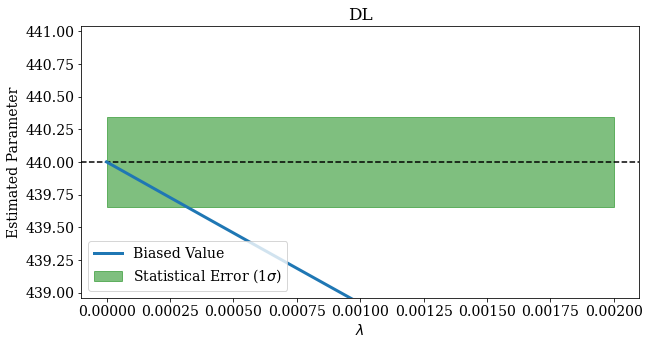

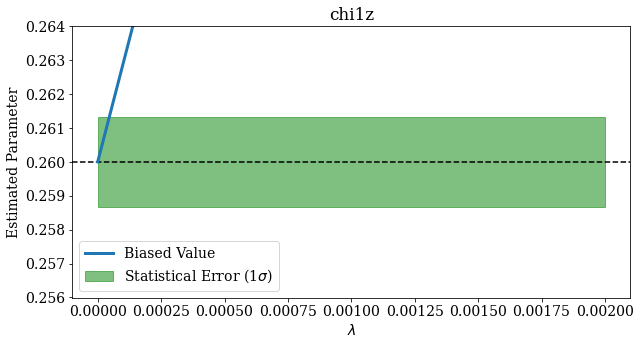

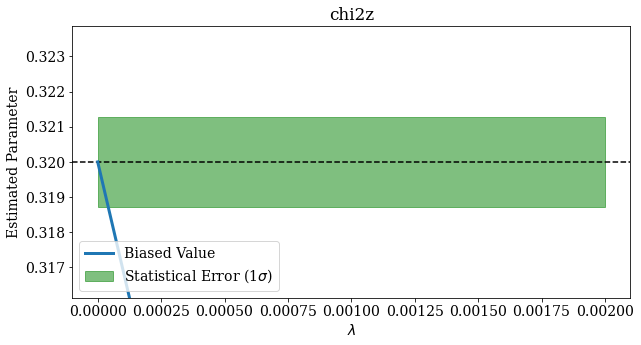

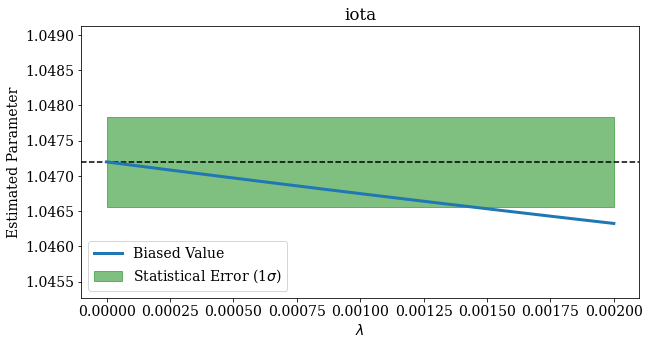

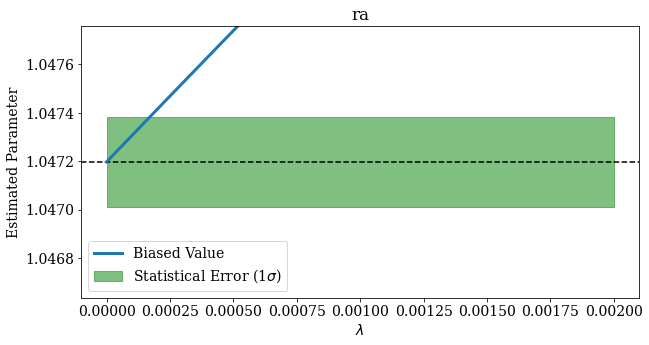

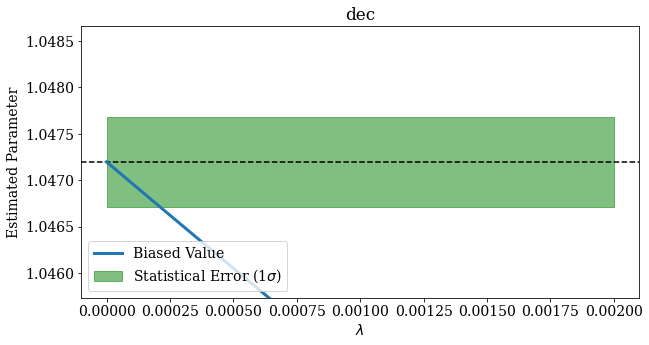

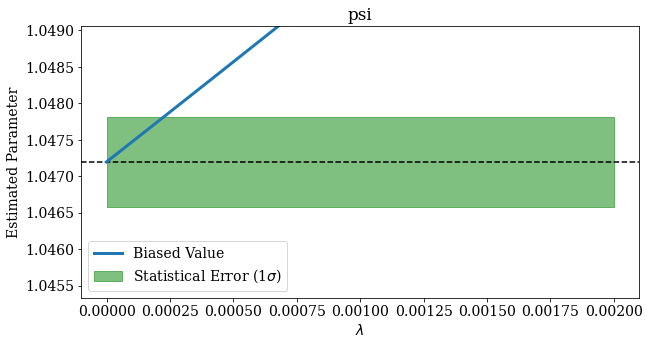

In [98]:
for p, param in enumerate(param_list):

    f, ax= plt.subplots(1, 1,  figsize=(10, 5)) 

    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    plt.axhline(mu, color='k', linestyle='--' )
    plt.fill_between(lams, mu-sigma, mu+sigma, alpha=0.5, color='g', label="Statistical Error (1$\sigma$)")
    plt.plot(lams, mu+errors_th_lam[:, p], color='C0', lw=3, label='Biased Value')

    plt.legend(loc="lower left")

    plt.ylabel(f"Estimated Parameter")
    plt.xlabel("$\lambda$")
    plt.title(param)

    plt.ylim(mu-3*sigma, mu+3*sigma)

    plt.show()